In [1]:
# pip install kaggle
# kaggle competitions download -c titanic

# TODO
- I'm crazy overfitting my data!
- How does regularization fit into all of this
- k-fold validation?
- can I get a learning curve? 
- which analytic methods can handle nonlinear relationships in features WITHOUT binning? I don't like turning fare and age into arbitrary bins

- Track my main differences from the tutorial: 
    - empirical assessment of continuous variables
        - `Fare` stays continuous
        - `Age`, `FamilySize`, `Title` are split into a few dummies
        - (tutorial binned them evenly and treated as continuous, at least in logistic regression)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Helpful functions

In [4]:
def bin_feature(df, feature, bins, convert_to_id = True, visualize = False):
    if convert_to_id: df[f'{feature}Id'] = pd.cut(df[feature], bins, right = False, labels=list(range(0,len(bins) - 1)))
    else: df[f'{feature}Id'] = pd.cut(df[feature], bins, right = False)
        
    assert(pd.isna(df[f'{feature}Id']).sum() == 0), f'NAs created by binning {feature}, check bins'
    
    if visualize:
        print(df[[f'{feature}Id', 'Survived']].groupby([f'{feature}Id'], as_index=False).mean().sort_values(by=f'{feature}Id', ascending=True))
        grid = sns.FacetGrid(df_train, size=5)
        grid.map(sns.pointplot, f'{feature}Id', 'Survived', 'Sex', palette='deep')
        grid.add_legend()
    
    return df

def make_feature_dummies(df, feature):
    dummies = pd.get_dummies(df[feature], prefix = feature)
    df = df.merge(dummies, left_index=True, right_index = True)
    return df
    
def count_missing_features(df):
    print(f'features with missing obs (n = {len(df.index)})')
    for col in df.columns:
        n_miss = pd.isna(df[col]).sum()
        if n_miss > 0: print(f'_{col}_ {n_miss}')
            
def check_for_any_na(df):
    missing_features = pd.isna(df).sum()
    n_miss = missing_features.sum() 
    if n_miss > 0: print(missing_features[missing_features > 0])
    assert (n_miss == 0), 'df has missing values'

In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
print(df_train.columns.values)
df_train.head()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Quick Examination of data

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Goodwin, Master. Harold Victor",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [8]:
print("df_train")
count_missing_features(df_train) 
print('_'*40)
print("df_test")
count_missing_features(df_test) 

df_train
features with missing obs (n = 891)
_Age_ 177
_Cabin_ 687
_Embarked_ 2
________________________________________
df_test
features with missing obs (n = 418)
_Age_ 86
_Fare_ 1
_Cabin_ 327


# Visualize Data
## Basic Demographics

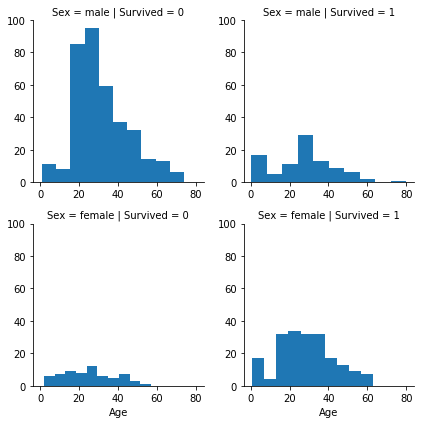

In [9]:
g = sns.FacetGrid(df_train, row = 'Sex', col='Survived')
g.map(plt.hist, 'Age', bins=10)
#g = sns.FacetGrid(df_train, row = 'Sex', col='Survived', hue = 'Pclass')
#g.map(sns.distplot, 'Age', bins=10, hist = False)
#g.add_legend()

## Survival by Class and Embarcation

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


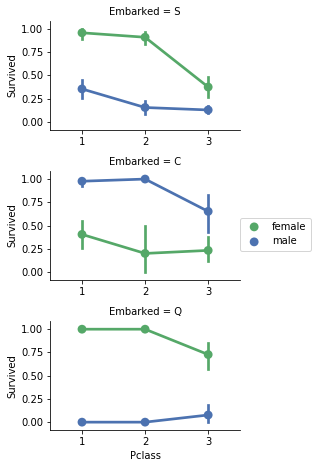

In [10]:
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


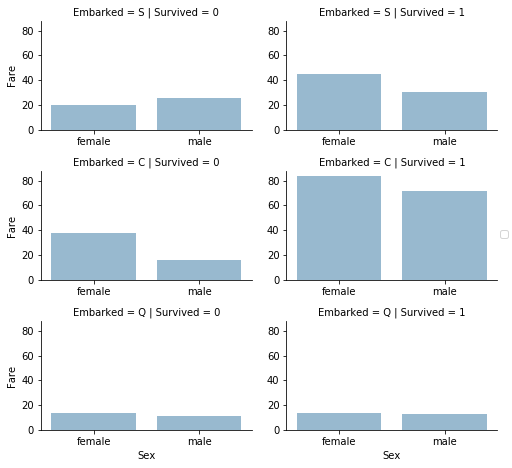

In [11]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# Feature Engineering
- `Title` from `Name`

In [12]:
title_mapping = {"Mr": "Mr", 
                 "Miss": "Miss", "Ms":"Miss", "Mlle": "Miss",
                 "Mrs": "Mrs", "Mme": "Mrs",
                 "Master": "Master"}

df_both = [df_train, df_test]
for dataset in df_both:
    dataset['Prefix'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    dataset['Title'] = dataset['Prefix'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna("Other")
    
df_test = make_feature_dummies(df_test, 'Title')
df_train = make_feature_dummies(df_train, 'Title')

# Convert to ordinal
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# for dataset in df_both:
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(0)

# pd.crosstab(df_train['Title'], df_train['Survived'], dropna = False)

In [13]:
#df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
pd.crosstab(df_train['Title'], df_train['Survived'], dropna = False)

Survived,0,1
Title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Other,15,8


In [14]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1


In [15]:
df_both = [df_train, df_test]
for dataset in df_both:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
# df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean() #.sort_values(by='Survived', ascending=False)

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


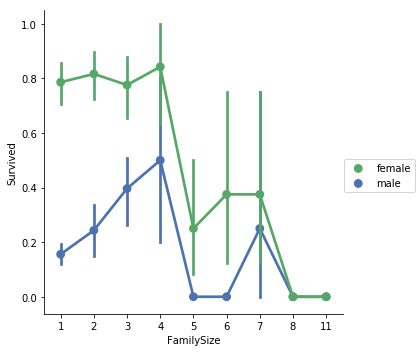

In [16]:
grid = sns.FacetGrid(df_train, size=5)
grid.map(sns.pointplot, 'FamilySize', 'Survived', 'Sex', palette='deep')
grid.add_legend()

  FamilySizeId  Survived
0       [1, 2)  0.303538
1       [2, 5)  0.578767
2      [5, 20)  0.161290


/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


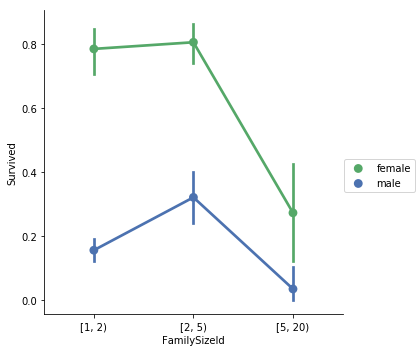

In [17]:
# Seems like 4 or less survive more (guessing it's a socioeconomic thing)
# BUT lonely males are not well off
bins = [1, 2, 5, 20]

df_train = bin_feature(df_train, 'FamilySize', bins, convert_to_id= False, visualize=True)
df_test = bin_feature(df_test, 'FamilySize', bins, convert_to_id= False, visualize=False)

In [18]:
# Make into dummies
df_train = make_feature_dummies(df_train, 'FamilySizeId')
df_test = make_feature_dummies(df_test, 'FamilySizeId')


In [19]:
# Map categorical features
df_both = [df_train, df_test]
for dataset in df_both:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# df_train['Sex'] = df_train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
# df_test['Sex'] = df_test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


# Impute Missing features
- age
Should do a proper imputation technique. for now, I will follow the advice of the tutorial (https://www.kaggle.com/startupsci/titanic-data-science-solutions) and use the median within. Should try a proper regression. Also may be worth using Title rather than class. 
- fare (JUST in testing data)

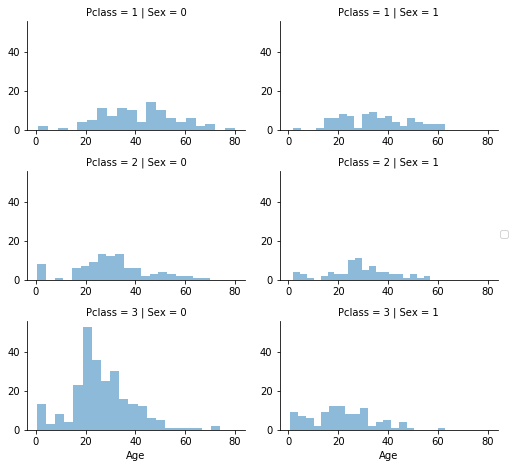

In [20]:
grid = sns.FacetGrid(df_train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
#grid = sns.FacetGrid(df_train, row='Title', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

guess_ages = np.zeros((2,3))

df_both = [df_train, df_test]
for dataset in df_both:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)


       AgeId  Survived
0    [0, 12)  0.573529
1   [12, 50)  0.368491
2  [50, 120)  0.364865


/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


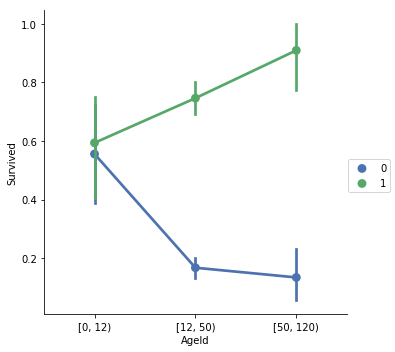

In [21]:
#bins = [0,5,10,12, 15] + np.linspace(20, 100, 9).tolist()
bins = [0,12,50,120]

df_train = bin_feature(df_train, 'Age', bins, convert_to_id = False, visualize=True)
df_test = bin_feature(df_test, 'Age', bins, convert_to_id = False, visualize=False)

df_train = make_feature_dummies(df_train, 'AgeId')
df_test = make_feature_dummies(df_test, 'AgeId')

In [22]:
# Impute embarked port with most frequent

In [23]:
freq_port = df_train.Embarked.dropna().mode()[0]

for dataset in df_both:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [24]:
# for dataset in df_both:
#     dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

df_train = make_feature_dummies(df_train, 'Embarked')
df_test = make_feature_dummies(df_test, 'Embarked')

In [25]:
#Replace one missing test data fare with median, then bin
df_test['Fare'].fillna(df_test['Fare'].dropna().median(), inplace=True)

             FareId  Survived
0       [0.0, 10.0)  0.199405
1      [10.0, 20.0)  0.424581
2      [20.0, 30.0)  0.426471
3      [30.0, 40.0)  0.437500
4      [40.0, 50.0)  0.266667
5      [50.0, 60.0)  0.692308
6      [60.0, 70.0)  0.352941
7      [70.0, 80.0)  0.586207
8      [80.0, 90.0)  0.866667
9     [90.0, 100.0)  0.875000
10  [100.0, 1000.0)  0.735849


/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


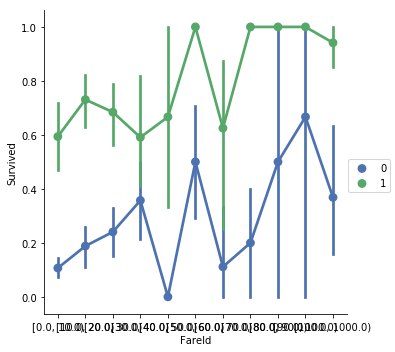

In [26]:
bins = [0,10,20,30,40,50, 100, 10000]
bins = np.linspace(0, 100, 11).tolist() + [1000]
df_train = bin_feature(df_train, 'Fare', bins, convert_to_id = False, visualize = True)

# Trend appears fairly linear, so I'll leave continuous and topcode 
for dataset in df_both: 
    dataset.loc[dataset['Fare'] > 100, 'Fare'] = 100


# Restrict to analytic features

In [27]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Prefix', 'Title',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'FamilySize', 'FamilySizeId', 'FamilySizeId_[1, 2)',
       'FamilySizeId_[2, 5)', 'FamilySizeId_[5, 20)', 'AgeId', 'AgeId_[0, 12)',
       'AgeId_[12, 50)', 'AgeId_[50, 120)', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'FareId'],
      dtype='object')

In [29]:
FamilySizeDummies = list(filter(lambda x:'FamilySizeId_' in x, df_train.columns.values.tolist()))
AgeDummies = list(filter(lambda x:'AgeId_' in x, df_train.columns.values.tolist()))
EmbarkedDummies = list(filter(lambda x:'Embarked_' in x, df_train.columns.values.tolist()))
TitleDummies = list(filter(lambda x:'Title_' in x, df_train.columns.values.tolist()))
dummies = FamilySizeDummies + AgeDummies + EmbarkedDummies + TitleDummies
dummies

['FamilySizeId_[1, 2)',
 'FamilySizeId_[2, 5)',
 'FamilySizeId_[5, 20)',
 'AgeId_[0, 12)',
 'AgeId_[12, 50)',
 'AgeId_[50, 120)',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Other']

In [30]:
#features = ['Pclass', 'Sex', 'AgeId', 'Fare', 'Embarked', 'Title', 'FamilySizeId']
features = ['Pclass', 'Sex', 'Fare'] + dummies


df_train = df_train[['Survived'] + features]
df_test = df_test[['PassengerId'] + features]

In [31]:
df_train.head()

,Survived,Pclass,Sex,Fare,"FamilySizeId_[1, 2)","FamilySizeId_[2, 5)","FamilySizeId_[5, 20)","AgeId_[0, 12)","AgeId_[12, 50)","AgeId_[50, 120)",Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,0,7.2500,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,1,1,1,71.2833,0,1,0,0,1,0,1,0,0,0,0,0,1,0
2,1,3,1,7.9250,1,0,0,0,1,0,0,0,1,0,1,0,0,0
3,1,1,1,53.1000,0,1,0,0,1,0,0,0,1,0,0,0,1,0
4,0,3,0,8.0500,1,0,0,0,1,0,0,0,1,0,0,1,0,0


In [39]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 17), (891,), (418, 17))

# SUPER RESTRICTED

In [55]:
X_train = df_train[['Pclass', 'Sex'] + AgeDummies]
Y_train = df_train["Survived"]
X_test  = df_test[['Pclass', 'Sex'] + AgeDummies].copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 5), (891,), (418, 5))

In [56]:
check_for_any_na(df_train)
check_for_any_na(df_test)

In [57]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.900000000000006

In [58]:
coeff_df = pd.DataFrame(df_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.533937
2,Fare,1.155182
3,"FamilySizeId_[1, 2)",0.114282
4,"FamilySizeId_[2, 5)",-0.556923
0,Pclass,-1.035430
5,"FamilySizeId_[5, 20)",NaN
6,"AgeId_[0, 12)",NaN
7,"AgeId_[12, 50)",NaN
8,"AgeId_[50, 120)",NaN
9,Embarked_C,NaN


In [59]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

80.129999999999995

In [60]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

77.890000000000001

In [61]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.120000000000005

In [62]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


80.019999999999996

In [63]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

78.900000000000006

In [64]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/share/code/zrankin/miniconda/envs/vivarium/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


78.450000000000003

In [65]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

80.25

In [66]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

80.25

In [67]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,80.25
8,Decision Tree,80.25
0,Support Vector Machines,80.13
5,Perceptron,80.02
4,Naive Bayes,79.12
2,Logistic Regression,78.90
7,Linear SVC,78.90
6,Stochastic Gradient Decent,78.45
1,KNN,77.89


In [52]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./output/submission.csv', index=False)


In [53]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [54]:
submission.Survived.mean()

0.37320574162679426

In [ ]:
# I'm crazy over-fitting, how good is a super simple Logistic prediction? 

In [34]:
df_train.head()

,Survived,Pclass,Sex,Fare,"FamilySizeId_[1, 2)","FamilySizeId_[2, 5)","FamilySizeId_[5, 20)","AgeId_[0, 12)","AgeId_[12, 50)","AgeId_[50, 120)",Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,0,7.2500,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,1,1,1,71.2833,0,1,0,0,1,0,1,0,0,0,0,0,1,0
2,1,3,1,7.9250,1,0,0,0,1,0,0,0,1,0,1,0,0,0
3,1,1,1,53.1000,0,1,0,0,1,0,0,0,1,0,0,0,1,0
4,0,3,0,8.0500,1,0,0,0,1,0,0,0,1,0,0,1,0,0


In [37]:
X_train = df_train[['Pclass', 'Sex'] + AgeDummies]
Y_train = df_train["Survived"]
X_test  = df_test[['Pclass', 'Sex'] + AgeDummies].copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 5), (891,), (418, 5))

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.900000000000006